In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm.auto import tqdm
from matplotlib.path import Path
import ast
import pickle
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
import networkx as nx

In [14]:
df = pd.read_csv("artworks_ordered.csv")
df[:5]

,Unnamed: 0.1,Unnamed: 0,id,name,path,center,area
0,5372,5372,txrg84,Flag of France,"{'109-164, T': [[249, 1469], [0, 1469], [0, 19...","{'109-164, T': [125, 1719]}",124500.0
1,1187,1187,twpyje,Flag of Germany,"{'109-166, T': [[0, 1121], [448, 1121], [447, ...","{'109-166, T': [992, 1148]}",96223.0
2,258,258,000354,The Nordic Union,"{'1-166, T': [[187, 93], [187, 97], [207, 97],...","{'1-166, T': [506, 129]}",89953.5
3,4866,4866,txd8wt,Central Alliance,"{'1-166, T': [[448, 890], [512, 890], [512, 90...","{'1-166, T': [447, 994]}",75325.5
4,7916,7916,ubyhtf,Netherlands,"{'56-166, T': [[297, 13], [297, 35], [886, 35]...","{'56-166, T': [1171, 19]}",54044.0


In [15]:
df = df[:5]

In [16]:
artworks = {}
id_count = 1
for row in df.itertuples():
    name = row.name
    path = row.path
    path = ast.literal_eval(path)
    coords = list(path.values())[0]
    artworks[id_count] = coords
    id_count += 1

In [17]:
# Flag of France
#art1 = [[125, 497], [175, 497], [175, 288], [171, 284], [171, 275], [148, 275], [148, 300], [141, 307], [141, 320], [152, 320], [152, 328], [125, 328], [125, 345], [132, 345], [132, 386], [125, 386]]
#flag of argentina
#art2 = [[1533, 1819], [1773, 1819], [1774, 1917], [1532, 1916]]

In [18]:
def find_points(art):
    x, y = np.meshgrid(np.arange(2000), np.arange(2000)) # make a canvas with coordinates
    x, y = x.flatten(), y.flatten()
    points = np.vstack((x,y)).T 

    p = Path(art) # make a polygon
    grid = p.contains_points(points,radius = 0)
    mask = grid.reshape(2000,2000) # now you have a mask with points inside a polygon
    x,y = mask.nonzero()
    coords = []
    for xc,yc in zip(x,y):
        coords.append((xc,yc))
    return coords

In [22]:
CHUNK_SIZE = 3_000_000
MIN_TILES = 200

f = open('./output/bipartite_network' + str(MIN_TILES) + '.csv', 'w')
counter = 0

for key in tqdm(artworks.keys()):
    art_pixel = find_points(artworks[key])
    s = set(art_pixel)
    name = key
    user_actions = {}
    l = []

    with pd.read_csv(
            'reddit_place_2022_trimmed.csv',
            chunksize=CHUNK_SIZE,
            engine="c",
            dtype={'timestamp':np.uint32,
              'user_id':np.uint32,
              'pixel_color':np.uint8,
              'x':np.uint16,
              'y':np.uint16,}
        ) as csv:
            for chunk in tqdm(csv):
                for row in chunk.itertuples():
                    user = row.user_id
                    x = row.x
                    y = row.y
                    if (x,y) in s:
                        if  user in user_actions:
                            user_actions[user] = user_actions[user] + 1 
                        else:
                            user_actions[user] = 1
               
    for user_key in user_actions.keys():
        if user_actions[user_key] > MIN_TILES:
            f.write(str(name) + ' ' + str(user_key) + '\n')
            l.append(user_actions[user_key])
            counter +=  1
            
    pickle.dump(l, open('./output/tiles/distrib_tiles_' + str(name) + '.pickle', "wb")) 
    print(counter)
f.close()

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

182


0it [00:00, ?it/s]

190


0it [00:00, ?it/s]

592


0it [00:00, ?it/s]

756


0it [00:00, ?it/s]

793


# analisi degli utenti interagenti

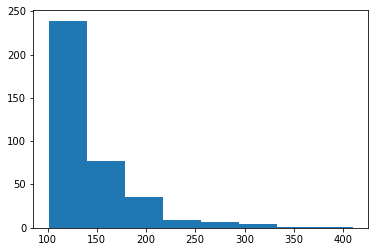

In [82]:
hist, bins, _ = plt.hist(l, bins=8)

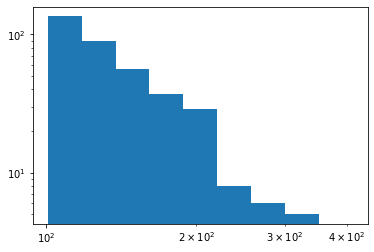

In [83]:
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),10)
plt.hist(l, bins=logbins)
plt.xscale('log')
plt.yscale('log')
plt.show()